# Skin Dideases 분류

1. 전이학습
2. 파인튜닝
3. 3가지 이상의 모델로 학습
4. 체크포인트 저장
5. 학습결과 시각화(텐서보드 활용)

In [1]:
print("hello")
# 환경 셋업 및 라이브러리 임포트
import torch
print(f'PyTorch version: {torch.__version__}')
import torch.nn as nn
print(f'CUDA available: {torch.cuda.is_available()}')
import torch.optim as optim
print(f'CUDA device count: {torch.cuda.device_count()}')
import torchvision
print(f'Torchvision version: {torchvision.__version__}')
import torchvision.transforms as transforms
print("Torchvision transforms")
from torch.utils.data import DataLoader
print(f'Torch DataLoader version: {DataLoader.__module__}')
from torchvision import datasets, models
print('Torchvision ')
import os
print('OS module')
import time
print('Time module')
import shutil
print('Shutil module')
import random
print('Random module')
import numpy as np
print('Numpy ')
from pathlib import Path
print('Pathlib')
print("=" * 50)
print("All libraries imported successfully")


hello
PyTorch version: 2.10.0
CUDA available: False
CUDA device count: 0
Torchvision version: 0.25.0
Torchvision transforms
Torch DataLoader version: torch.utils.data.dataloader
Torchvision 
OS module
Time module
Shutil module
Random module
Numpy 
Pathlib
All libraries imported successfully


In [ ]:
from pathlib import Path
import random, shutil

# 원본 데이터: ./data/skin/train/<class>/*.*
src_root = Path("./data/skin")
src_train = src_root / "train"

# 목적지: ./dataset/skin/train, ./dataset/skin/test
dst_train_root = Path("./dataset/skin/train")
dst_test_root  = Path("./dataset/skin/test")

train_ratio = 0.8
seed = 42
random.seed(seed)

valid_ext = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

# --- sanity check ---
assert src_root.exists(), f"src_root not found: {src_root.resolve()}"
assert src_train.exists(), f"src_train not found: {src_train.resolve()}"

class_dirs = [d for d in src_train.iterdir() if d.is_dir()]
print("Found classes:", [d.name for d in class_dirs])

for class_dir in class_dirs:
    # 대상 클래스 폴더 생성
    (dst_train_root / class_dir.name).mkdir(parents=True, exist_ok=True)
    (dst_test_root  / class_dir.name).mkdir(parents=True, exist_ok=True)

    # 이미지 수집(확장자 대소문자 대응)
    files = [p for p in class_dir.iterdir()
             if p.is_file() and p.suffix.lower() in valid_ext]

    if len(files) == 0:
        print(f"[WARN] no valid images in: {class_dir}")
        continue

    random.shuffle(files)
    n_train = int(len(files) * train_ratio)
    train_files = files[:n_train]
    test_files  = files[n_train:]

    # 복사
    for p in train_files:
        shutil.copy2(p, dst_train_root / class_dir.name / p.name)
    for p in test_files:
        shutil.copy2(p, dst_test_root / class_dir.name / p.name)

    print(f"{class_dir.name}: total={len(files)}, train={len(train_files)}, test={len(test_files)}")

In [3]:
train_dir = Path("./dataset/skin/train")
test_dir  = Path("./dataset/skin/test")

valid_ext = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

# 데이터 전처리
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(0.15, 0.15, 0.10, 0.02),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

train_dataset = datasets.ImageFolder(root=str(train_dir), transform=train_transform)
test_dataset  = datasets.ImageFolder(root=str(test_dir),  transform=eval_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                          num_workers=2, persistent_workers=True)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False,
                          num_workers=2, persistent_workers=True)

In [4]:
# cuda 설정
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f'Using device: {device}')


Using device: mps


In [5]:
print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

{'acne': 0, 'eksim': 1, 'herpes': 2, 'panu': 3, 'rosacea': 4}
{'acne': 0, 'eksim': 1, 'herpes': 2, 'panu': 3, 'rosacea': 4}


# 전이학습
### 모델 1 - EfficientNetV2-S

In [6]:
# 전이학습 모델 1 - EfficientNetV2-S 모델 불러오기, pretrained=True로 사전학습된 가중치 로드
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT).to(device)
print("EfficientNetV2-S model loaded")

model

EfficientNetV2-S model loaded


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [11]:
# 체크포인트 및 텐서보드 콜백
checkpoint_path = "./checkpoints/efficientnetv2_s.pth"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

In [7]:
# classifier 외 모델의 모든 파라미터 동결
for param in model.parameters():
    param.requires_grad = False

# classifier 교체
in_features = model.classifier[1].in_features

model.classifier[1] = nn.Linear(in_features, 5)

model = model.to(device)

# classifier만 학습 가능
for param in model.classifier.parameters():
    param.requires_grad = True

In [8]:
for name, param in model.named_parameters():
    print(name, param.requires_grad) # 각 파라미터의 requires_grad 상태 출력

features.0.0.weight False
features.0.1.weight False
features.0.1.bias False
features.1.0.block.0.0.weight False
features.1.0.block.0.1.weight False
features.1.0.block.0.1.bias False
features.1.1.block.0.0.weight False
features.1.1.block.0.1.weight False
features.1.1.block.0.1.bias False
features.2.0.block.0.0.weight False
features.2.0.block.0.1.weight False
features.2.0.block.0.1.bias False
features.2.0.block.1.0.weight False
features.2.0.block.1.1.weight False
features.2.0.block.1.1.bias False
features.2.1.block.0.0.weight False
features.2.1.block.0.1.weight False
features.2.1.block.0.1.bias False
features.2.1.block.1.0.weight False
features.2.1.block.1.1.weight False
features.2.1.block.1.1.bias False
features.2.2.block.0.0.weight False
features.2.2.block.0.1.weight False
features.2.2.block.0.1.bias False
features.2.2.block.1.0.weight False
features.2.2.block.1.1.weight False
features.2.2.block.1.1.bias False
features.2.3.block.0.0.weight False
features.2.3.block.0.1.weight False
feat

In [9]:
# 손실과 옵티마이저 설정
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

In [12]:
# 모델 학습 루프: 체크포인트, 텐서보드, tqdm 진행바
import tqdm
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # 체크포인트 저장
    torch.save(model.state_dict(), checkpoint_path)

Epoch 1/10: 100%|██████████| 75/75 [00:15<00:00,  4.76it/s]


Epoch 1/10, Loss: 1.1530, Accuracy: 0.6633


Epoch 2/10: 100%|██████████| 75/75 [00:15<00:00,  4.78it/s]


Epoch 2/10, Loss: 1.0548, Accuracy: 0.6968


Epoch 3/10: 100%|██████████| 75/75 [00:15<00:00,  4.78it/s]


Epoch 3/10, Loss: 1.0282, Accuracy: 0.6977


Epoch 4/10: 100%|██████████| 75/75 [00:15<00:00,  4.76it/s]


Epoch 4/10, Loss: 0.9858, Accuracy: 0.7111


Epoch 5/10: 100%|██████████| 75/75 [00:15<00:00,  4.73it/s]


Epoch 5/10, Loss: 0.9636, Accuracy: 0.7303


Epoch 6/10: 100%|██████████| 75/75 [00:15<00:00,  4.72it/s]


Epoch 6/10, Loss: 0.9301, Accuracy: 0.7471


Epoch 7/10: 100%|██████████| 75/75 [00:16<00:00,  4.67it/s]


Epoch 7/10, Loss: 0.9048, Accuracy: 0.7596


Epoch 8/10: 100%|██████████| 75/75 [00:16<00:00,  4.51it/s]


Epoch 8/10, Loss: 0.9204, Accuracy: 0.7504


Epoch 9/10: 100%|██████████| 75/75 [00:16<00:00,  4.44it/s]


Epoch 9/10, Loss: 0.9160, Accuracy: 0.7479


Epoch 10/10: 100%|██████████| 75/75 [00:17<00:00,  4.38it/s]


Epoch 10/10, Loss: 0.9028, Accuracy: 0.7571


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6041614..2.5528543].


torch.Size([3, 224, 224]) 0


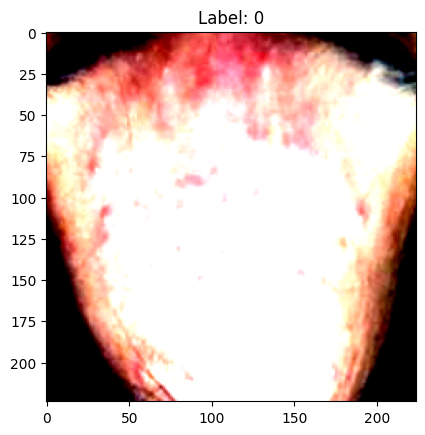

In [13]:
import matplotlib.pyplot as plt
import numpy as np
img, lablel = train_dataset[92]
print(img.shape, lablel)
plt.imshow(img.permute(1, 2, 0))
plt.title(f'Label: {lablel}')
plt.show()

In [14]:
# 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.7733


In [15]:
# 파인튜닝 준비: 뒤쪽 블록만 unfreeze
# 1) 먼저 전부 freeze
for p in model.features.parameters():
    p.requires_grad = False

# 2) 마지막 N개 블록 unfreeze
N = 2
for block in list(model.features.children())[-N:]:
    for p in block.parameters():
        p.requires_grad = True

# 3) classifier는 계속 학습
for p in model.classifier.parameters():
    p.requires_grad = True


In [16]:
# BatchNorm 처리
import torch.nn as nn

def set_bn_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()

model.apply(set_bn_eval)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [17]:
# optimizer 재설정 (unfreeze된 파라미터만)
import torch.optim as optim

backbone_params = [p for p in model.features.parameters() if p.requires_grad]
head_params = [p for p in model.classifier.parameters() if p.requires_grad]

optimizer = optim.AdamW(
    [
        {"params": backbone_params, "lr": 2e-5},
        {"params": head_params, "lr": 2e-4},
    ],
    weight_decay=1e-4
)

In [18]:
for name, param in model.named_parameters():
    print(name, param.requires_grad) # 각 파라미터의 requires_grad 상태 출력

features.0.0.weight False
features.0.1.weight False
features.0.1.bias False
features.1.0.block.0.0.weight False
features.1.0.block.0.1.weight False
features.1.0.block.0.1.bias False
features.1.1.block.0.0.weight False
features.1.1.block.0.1.weight False
features.1.1.block.0.1.bias False
features.2.0.block.0.0.weight False
features.2.0.block.0.1.weight False
features.2.0.block.0.1.bias False
features.2.0.block.1.0.weight False
features.2.0.block.1.1.weight False
features.2.0.block.1.1.bias False
features.2.1.block.0.0.weight False
features.2.1.block.0.1.weight False
features.2.1.block.0.1.bias False
features.2.1.block.1.0.weight False
features.2.1.block.1.1.weight False
features.2.1.block.1.1.bias False
features.2.2.block.0.0.weight False
features.2.2.block.0.1.weight False
features.2.2.block.0.1.bias False
features.2.2.block.1.0.weight False
features.2.2.block.1.1.weight False
features.2.2.block.1.1.bias False
features.2.3.block.0.0.weight False
features.2.3.block.0.1.weight False
feat

In [19]:
# 파인튜닝 학습 루프
fine_tune_epochs = 10

for epoch in range(fine_tune_epochs):
    model.train()
    model.apply(set_bn_eval)  # BN 고정 유지

    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        pred = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    print(f"[FT {epoch+1}/{fine_tune_epochs}] loss={running_loss/len(train_dataset):.4f}, acc={correct/total:.4f}")

    # 체크포인트 (val 기준이 제일 좋지만, 최소한 epoch별 저장)
    torch.save(model.state_dict(), checkpoint_path)

[FT 1/10] loss=0.8359, acc=0.8015
[FT 2/10] loss=0.7222, acc=0.8610
[FT 3/10] loss=3.4083, acc=0.8987
[FT 4/10] loss=0.6414, acc=0.9087
[FT 5/10] loss=0.5844, acc=0.9447
[FT 6/10] loss=0.6668, acc=0.9087
[FT 7/10] loss=0.6570, acc=0.8970
[FT 8/10] loss=0.5840, acc=0.9422
[FT 9/10] loss=0.5694, acc=0.9506
[FT 10/10] loss=0.5531, acc=0.9573


In [20]:
# 파인튜닝 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9500


In [21]:
# 모델 저장
torch.save(model.state_dict(), 'fine_tuned_model.pth')

In [ ]:
"""
# 파인튜닝 모델 불러와서 새로운 데이터셋으로 평가
model_path = "./fine_tuned_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model
"""

In [22]:
# 새로운 데이터 불러오기
new_data_dir = Path("data/skin_test")
new_dataset = datasets.ImageFolder(root=new_data_dir, transform=eval_transform)


In [23]:
# 새로운 데이터로 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in DataLoader(new_dataset, batch_size=32, shuffle=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6600


In [24]:
# 파인튜닝 2 준비: 뒤쪽 블록만 unfreeze
# 1) 먼저 전부 freeze
for p in model.features.parameters():
    p.requires_grad = False

# 2) 마지막 N개 블록 unfreeze
N = 4
for block in list(model.features.children())[-N:]:
    for p in block.parameters():
        p.requires_grad = True

# 3) classifier는 계속 학습
for p in model.classifier.parameters():
    p.requires_grad = True

# BatchNorm 처리
import torch.nn as nn

def set_bn_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()

model.apply(set_bn_eval)

# optimizer 재설정 (unfreeze된 파라미터만)
import torch.optim as optim

backbone_params = [p for p in model.features.parameters() if p.requires_grad]
head_params = [p for p in model.classifier.parameters() if p.requires_grad]

optimizer = optim.AdamW(
    [
        {"params": backbone_params, "lr": 3e-5},
        {"params": head_params, "lr": 3e-4},
    ],
    weight_decay=1e-5
)

for name, param in model.named_parameters():
    print(name, param.requires_grad) # 각 파라미터의 requires_grad 상태 출력

features.0.0.weight False
features.0.1.weight False
features.0.1.bias False
features.1.0.block.0.0.weight False
features.1.0.block.0.1.weight False
features.1.0.block.0.1.bias False
features.1.1.block.0.0.weight False
features.1.1.block.0.1.weight False
features.1.1.block.0.1.bias False
features.2.0.block.0.0.weight False
features.2.0.block.0.1.weight False
features.2.0.block.0.1.bias False
features.2.0.block.1.0.weight False
features.2.0.block.1.1.weight False
features.2.0.block.1.1.bias False
features.2.1.block.0.0.weight False
features.2.1.block.0.1.weight False
features.2.1.block.0.1.bias False
features.2.1.block.1.0.weight False
features.2.1.block.1.1.weight False
features.2.1.block.1.1.bias False
features.2.2.block.0.0.weight False
features.2.2.block.0.1.weight False
features.2.2.block.0.1.bias False
features.2.2.block.1.0.weight False
features.2.2.block.1.1.weight False
features.2.2.block.1.1.bias False
features.2.3.block.0.0.weight False
features.2.3.block.0.1.weight False
feat

In [25]:
# 파인튜닝 학습 루프
fine_tune_epochs = 10

# tqdm 진행바 추가
import tqdm

for epoch in range(fine_tune_epochs):
    model.train()
    model.apply(set_bn_eval)  # BN 고정 유지

    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm.tqdm(train_loader, desc=f"Fine-tuning Epoch {epoch+1}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        pred = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    print(f"[FT {epoch+1}/{fine_tune_epochs}] loss={running_loss/len(train_dataset):.4f}, acc={correct/total:.4f}")

    # 체크포인트 (val 기준이 제일 좋지만, 최소한 epoch별 저장)
    torch.save(model.state_dict(), checkpoint_path)

Fine-tuning Epoch 1: 100%|██████████| 75/75 [00:44<00:00,  1.68it/s]


[FT 1/10] loss=1.3559, acc=0.9255


Fine-tuning Epoch 2: 100%|██████████| 75/75 [00:46<00:00,  1.60it/s]


[FT 2/10] loss=1.1463, acc=0.9422


Fine-tuning Epoch 3: 100%|██████████| 75/75 [00:48<00:00,  1.54it/s]


[FT 3/10] loss=132.5549, acc=0.9204


Fine-tuning Epoch 4: 100%|██████████| 75/75 [00:52<00:00,  1.43it/s]


[FT 4/10] loss=0.6020, acc=0.9246


Fine-tuning Epoch 5: 100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


[FT 5/10] loss=0.5890, acc=0.9548


Fine-tuning Epoch 6: 100%|██████████| 75/75 [00:51<00:00,  1.46it/s]


[FT 6/10] loss=0.5531, acc=0.9531


Fine-tuning Epoch 7: 100%|██████████| 75/75 [00:50<00:00,  1.49it/s]


[FT 7/10] loss=0.5296, acc=0.9657


Fine-tuning Epoch 8: 100%|██████████| 75/75 [00:50<00:00,  1.48it/s]


[FT 8/10] loss=0.5171, acc=0.9765


Fine-tuning Epoch 9: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s]


[FT 9/10] loss=3.3880, acc=0.9824


Fine-tuning Epoch 10: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s]


[FT 10/10] loss=0.4981, acc=0.9799


In [26]:
# 파인튜닝 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = correct / total
print(f"Dataset Test Accuracy: {test_acc:.4f}")

# 새로운 데이터로 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in DataLoader(new_dataset, batch_size=32, shuffle=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = correct / total
print(f"New Dataset Test Accuracy: {test_acc:.4f}")

Dataset Test Accuracy: 0.9733
New Dataset Test Accuracy: 0.6800


### 모델 2 - ConvNeXt-Tiny

In [ ]:
# 모델 불러오기: convnext_tiny
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)

# head 교체
in_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_features, 5)

model = model.to(device)

In [ ]:
# backbone 동결
for param in model.features.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
for name, param in model.named_parameters():
    print(name, param.requires_grad) # 각 파라미터의 requires_grad 상태 출력

In [ ]:
# optimizer 설정
optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-3, weight_decay=1e-4)

In [ ]:
# 전처리 변경: convnext_tiny는 224x224, EfficientNetV2-S는 384x384
transform = transforms.Compose([
    transforms.Resize((224, 224)), # 이미지 크기 조정
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 정규화
])

weights = models.ConvNeXt_Tiny_Weights.DEFAULT
preprocess = weights.transforms()

In [ ]:
# 모델 학습 루프: 체크포인트, 텐서보드, tqdm 진행바
num_epochs = 10
criterion = nn.CrossEntropyLoss()
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # 체크포인트 저장
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
        'accuracy': epoch_acc
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch+1}.pth')

In [ ]:
# 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
# 새로운 데이터 불러오기
new_data_dir = Path("./data/skin_test")
new_dataset = datasets.ImageFolder(root=new_data_dir, transform=transform)

# 새로운 데이터로 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in DataLoader(new_dataset, batch_size=32, shuffle=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        img_grid = torchvision.utils.make_grid(inputs.cpu())
        plt.imshow(img_grid.permute(1,2,0))
        plt.title(f'Predicted: {new_dataset.classes[predicted[0]]}, Actual: {new_dataset.classes[labels[0]]}')
        plt.show()
test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

### 모델 3 - MobileNetV3-Large